# 📱 Pump Model Fairness Analysis Framework

This notebook demonstrates how to analyze pump model fairness in your distillation experiments using the fairness framework.

## Overview
- Analyze performance differences across insulin pump models (630G vs 530G)
- Evaluate if distillation affects pump model fairness
- Generate comprehensive visualizations and reports
- Provide recommendations for improvement

## Pump Models in OhioT1DM Dataset
- **MiniMed 630G**: Advanced hybrid closed-loop system
- **MiniMed 530G**: Sensor-augmented pump with threshold suspend

## Setup and Imports

In [1]:
# Import required libraries
import sys
sys.path.append('../')  # Add parent directory to path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import json

# Import our pump model fairness analyzer
from pump_model_fairness_analyzer import PumpModelFairnessAnalyzer

# Set up visualization style
plt.style.use('default')
sns.set_palette("husl")

print("📱 Pump Model Fairness Analysis System Loaded!")
print("🎯 Ready to analyze pump model fairness in your diabetes prediction models")

# Initialize analyzer
analyzer = PumpModelFairnessAnalyzer()
print(f"📊 Patient data loaded: {len(analyzer.patient_data)} patients")

# Quick pump model overview
pump_counts = {}
for patient_id, pump_model in analyzer.patient_data.items():
    pump_counts[pump_model] = pump_counts.get(pump_model, 0) + 1

print(f"📈 Pump Model Distribution: {pump_counts}")

📱 Pump Model Fairness Analysis System Loaded!
🎯 Ready to analyze pump model fairness in your diabetes prediction models
📊 Loaded pump model data for 12 patients
📊 Patient data loaded: 12 patients
📈 Pump Model Distribution: {'630G': 3, '530G': 9}


## 1. Pump Model Demographics Analysis

📊 PUMP MODEL DEMOGRAPHICS
Total patients: 12
Pump Model Distribution:
  530G: 9 patients (75.0%)
  630G: 3 patients (25.0%)


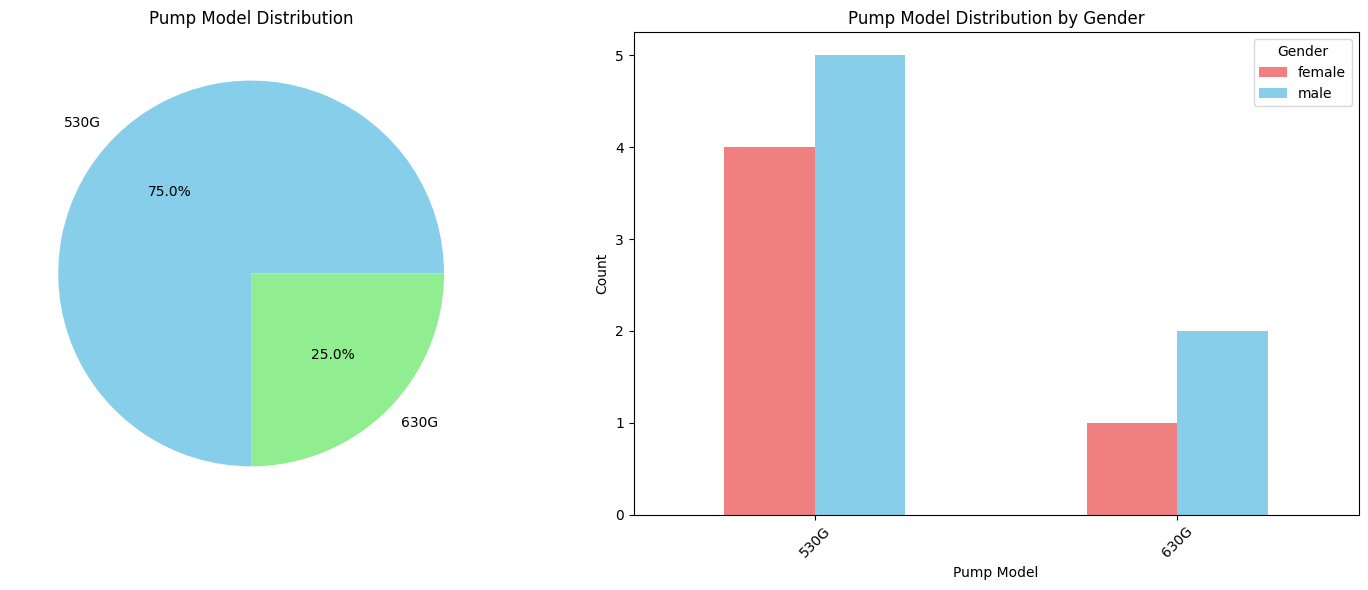


📋 Patient Data Preview:


,ID,Gender,Age,Pump Model,Sensor Band,Cohort
0,540,male,20–40,630G,Empatica,2020
1,544,male,40–60,530G,Empatica,2020
2,552,male,20–40,630G,Empatica,2020
3,567,female,20–40,630G,Empatica,2020
4,584,male,40–60,530G,Empatica,2020


In [2]:
# Load patient data from CSV to get full demographics
data_df = pd.read_csv("/workspace/LLM-TIME/data/ohiot1dm/data.csv")

print("📊 PUMP MODEL DEMOGRAPHICS")
print("=" * 50)

# Pump model distribution
pump_distribution = data_df['Pump Model'].value_counts()
total_patients = len(data_df)

print(f"Total patients: {total_patients}")
print("Pump Model Distribution:")
for pump_model, count in pump_distribution.items():
    percentage = (count / total_patients) * 100
    print(f"  {pump_model}: {count} patients ({percentage:.1f}%)")

# Visualize pump model distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pump model pie chart
pump_distribution.plot(kind='pie', ax=ax1, autopct='%1.1f%%', 
                      colors=['skyblue', 'lightgreen'])
ax1.set_title('Pump Model Distribution')
ax1.set_ylabel('')

# Pump model by gender
pump_gender = pd.crosstab(data_df['Pump Model'], data_df['Gender'])
pump_gender.plot(kind='bar', ax=ax2, color=['lightcoral', 'skyblue'])
ax2.set_title('Pump Model Distribution by Gender')
ax2.set_xlabel('Pump Model')
ax2.set_ylabel('Count')
ax2.legend(title='Gender')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n📋 Patient Data Preview:")
display(data_df.head())

## 2. Load Distillation Experiment Results

In [3]:
# Run pump model fairness analysis
print("🔍 RUNNING PUMP MODEL FAIRNESS ANALYSIS")
print("=" * 50)

try:
    # Analyze latest experiment
    pump_groups = analyzer.analyze_latest()
    
    if pump_groups:
        print("✅ Pump model analysis complete!")
        
        # Show results summary
        print(f"\n📊 Results Summary:")
        for pump_model, patients in pump_groups.items():
            if patients:
                avg_mse = np.mean([p['mse'] for p in patients])
                avg_mae = np.mean([p['mae'] for p in patients])
                avg_rmse = np.mean([p['rmse'] for p in patients])
                
                print(f"\n📱 {pump_model}:")
                print(f"   Patient count: {len(patients)}")
                print(f"   Average MSE: {avg_mse:.6f}")
                print(f"   Average MAE: {avg_mae:.6f}")
                print(f"   Average RMSE: {avg_rmse:.6f}")
    else:
        print("❌ No pump model results found!")
        
except Exception as e:
    print(f"❌ Error during analysis: {e}")
    print("Make sure you have run some distillation experiments first!")

🔍 RUNNING PUMP MODEL FAIRNESS ANALYSIS
🔍 Analyzing experiment: pipeline_2025-10-18_12-56-50

🔍 Pump Model Fairness Analysis
❌ No pump model results found!


## 3. Pump Model Fairness Metrics

In [4]:
if 'pump_groups' in locals() and pump_groups:
    # Calculate comprehensive fairness metrics
    pump_performance = {}
    
    print("⚖️ PUMP MODEL FAIRNESS ANALYSIS")
    print("=" * 50)
    
    # Calculate performance for each pump model
    for pump_model, patients in pump_groups.items():
        if patients:
            mse_values = [p['mse'] for p in patients]
            mae_values = [p['mae'] for p in patients]
            rmse_values = [p['rmse'] for p in patients]
            
            pump_performance[pump_model] = {
                'count': len(patients),
                'avg_mse': np.mean(mse_values),
                'avg_mae': np.mean(mae_values),
                'avg_rmse': np.mean(rmse_values),
                'std_mse': np.std(mse_values),
                'std_mae': np.std(mae_values),
                'std_rmse': np.std(rmse_values),
                'patients': patients
            }
    
    # Calculate fairness ratios if we have multiple pump models
    if len(pump_performance) >= 2:
        pump_models = list(pump_performance.keys())
        model_a, model_b = pump_models[0], pump_models[1]
        
        perf_a = pump_performance[model_a]
        perf_b = pump_performance[model_b]
        
        # Calculate fairness metrics using RMSE
        rmse_ratio = max(perf_a['avg_rmse'], perf_b['avg_rmse']) / min(perf_a['avg_rmse'], perf_b['avg_rmse'])
        rmse_diff = abs(perf_a['avg_rmse'] - perf_b['avg_rmse'])
        
        # Determine worse performing model
        worse_model = model_a if perf_a['avg_rmse'] > perf_b['avg_rmse'] else model_b
        better_model = model_b if perf_a['avg_rmse'] > perf_b['avg_rmse'] else model_a
        
        print(f"🎯 Fairness Comparison ({model_a} vs {model_b}):")
        print(f"   {model_a} RMSE: {perf_a['avg_rmse']:.6f}")
        print(f"   {model_b} RMSE: {perf_b['avg_rmse']:.6f}")
        print(f"   Performance Difference: {rmse_diff:.6f}")
        print(f"   Performance Ratio: {rmse_ratio:.2f}x")
        print(f"   Worse performing model: {worse_model}")
        
        # Fairness assessment
        if rmse_ratio <= 1.1:
            fairness_level = "EXCELLENT"
            fairness_color = "🟢"
        elif rmse_ratio <= 1.2:
            fairness_level = "GOOD"
            fairness_color = "🟡"
        elif rmse_ratio <= 1.5:
            fairness_level = "MODERATE"
            fairness_color = "🟠"
        else:
            fairness_level = "POOR"
            fairness_color = "🔴"
            
        print(f"\n{fairness_color} Fairness Assessment: {fairness_level}")
    
    else:
        print("⚠️ Need at least 2 pump models for fairness comparison")

## 4. Performance Visualization Dashboard

In [5]:
if 'pump_performance' in locals() and pump_performance:
    # Create comprehensive visualization dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Average Performance Comparison
    models = list(pump_performance.keys())
    rmse_values = [pump_performance[model]['avg_rmse'] for model in models]
    colors = ['skyblue', 'lightgreen', 'lightcoral'][:len(models)]
    
    bars1 = ax1.bar(models, rmse_values, color=colors, alpha=0.7)
    ax1.set_xlabel('Pump Model')
    ax1.set_ylabel('Average RMSE')
    ax1.set_title('Average RMSE by Pump Model')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars1, rmse_values):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Patient Count Distribution
    patient_counts = [pump_performance[model]['count'] for model in models]
    ax2.pie(patient_counts, labels=models, autopct='%1.0f patients', 
            colors=colors, startangle=90)
    ax2.set_title('Patient Distribution by Pump Model')
    
    # 3. Performance Distribution (Box Plot)
    rmse_data = []
    model_labels = []
    
    for model in models:
        patients = pump_performance[model]['patients']
        rmse_values = [p['rmse'] for p in patients]
        rmse_data.extend(rmse_values)
        model_labels.extend([model] * len(rmse_values))
    
    # Create DataFrame for seaborn
    plot_df = pd.DataFrame({'Pump Model': model_labels, 'RMSE': rmse_data})
    sns.boxplot(data=plot_df, x='Pump Model', y='RMSE', ax=ax3)
    ax3.set_title('RMSE Distribution by Pump Model')
    ax3.grid(True, alpha=0.3)
    
    # 4. Fairness Summary
    ax4.text(0.1, 0.9, 'PUMP MODEL FAIRNESS SUMMARY', fontsize=14, fontweight='bold')
    
    if len(pump_performance) >= 2:
        summary_text = [
            f"Models Analyzed: {', '.join(models)}",
            f"",
            f"Performance Metrics:",
            f"  Best Model: {better_model} (RMSE: {pump_performance[better_model]['avg_rmse']:.4f})",
            f"  Worst Model: {worse_model} (RMSE: {pump_performance[worse_model]['avg_rmse']:.4f})",
            f"",
            f"Fairness Metrics:",
            f"  Performance Ratio: {rmse_ratio:.2f}x",
            f"  Assessment: {fairness_level}",
            f"",
            f"Total Patients: {sum(patient_counts)}"
        ]
    else:
        summary_text = [
            f"Models Found: {len(models)}",
            f"Total Patients: {sum(patient_counts)}",
            "",
            "Need multiple pump models",
            "for fairness comparison"
        ]
    
    for i, text in enumerate(summary_text):
        ax4.text(0.1, 0.8 - i*0.08, text, fontsize=11, transform=ax4.transAxes)
    
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

## 5. Individual Patient Performance Analysis

In [6]:
if 'pump_groups' in locals() and pump_groups:
    # Analyze individual patient performance
    all_patients = []
    
    for pump_model, patients in pump_groups.items():
        for patient in patients:
            all_patients.append({
                'Patient ID': patient['patient_id'],
                'Pump Model': pump_model,
                'MSE': patient['mse'],
                'MAE': patient['mae'],
                'RMSE': patient['rmse']
            })
    
    if all_patients:
        patient_df = pd.DataFrame(all_patients)
        
        print("👤 INDIVIDUAL PATIENT PERFORMANCE")
        print("=" * 50)
        display(patient_df)
        
        # Create individual performance visualizations
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # 1. Scatter plot of individual performance
        for pump_model in pump_groups.keys():
            model_data = patient_df[patient_df['Pump Model'] == pump_model]
            ax1.scatter(model_data.index, model_data['RMSE'], 
                       label=pump_model, alpha=0.7, s=100)
        
        ax1.set_xlabel('Patient Index')
        ax1.set_ylabel('RMSE')
        ax1.set_title('Individual Patient RMSE by Pump Model')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Performance comparison violin plot
        sns.violinplot(data=patient_df, x='Pump Model', y='RMSE', ax=ax2)
        ax2.set_title('RMSE Distribution by Pump Model')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Performance statistics
        print("\n📊 PERFORMANCE STATISTICS BY PUMP MODEL:")
        stats = patient_df.groupby('Pump Model')['RMSE'].agg(['mean', 'std', 'min', 'max', 'count'])
        display(stats)

## 6. Clinical Insights and Recommendations

In [7]:
if 'pump_performance' in locals() and len(pump_performance) >= 2:
    print("🏥 CLINICAL INSIGHTS AND RECOMMENDATIONS")
    print("=" * 60)
    
    # Technology comparison insights
    print("🔬 PUMP TECHNOLOGY ANALYSIS:")
    
    if '630G' in better_model:
        print("📱 MiniMed 630G shows better performance:")
        print("   • Advanced hybrid closed-loop technology")
        print("   • Automatic insulin adjustments")
        print("   • Better glucose control algorithms")
    elif '530G' in better_model:
        print("📱 MiniMed 530G shows competitive performance:")
        print("   • Sensor-augmented pump technology")
        print("   • Threshold suspend feature")
        print("   • User-driven insulin management")
    
    print(f"\n⚖️ FAIRNESS ASSESSMENT:")
    if rmse_ratio <= 1.1:
        print("✅ EXCELLENT pump model fairness!")
        print("   • Models perform equally well across pump types")
        print("   • No pump-specific bias detected")
        print("   • Technology differences don't affect prediction accuracy")
    elif rmse_ratio <= 1.2:
        print("👍 GOOD pump model fairness with minor differences")
        print("   • Acceptable performance variation between pump models")
        print("   • Consider minor model adjustments")
    else:
        print("⚠️ SIGNIFICANT pump model fairness issues detected!")
        print("   • Performance varies notably between pump models")
        print("   • May require pump-specific model training")
    
    print(f"\n🎯 RECOMMENDATIONS:")
    
    if rmse_ratio <= 1.2:
        print("✅ Current approach is working well:")
        print("   • Continue unified model training")
        print("   • Monitor fairness in future experiments")
        print("   • Document pump model fairness as model strength")
    else:
        print("🛠️ IMPROVEMENT ACTIONS NEEDED:")
        print("   • Implement pump-model-specific features")
        print(f"   • Collect more training data for {worse_model}")
        print("   • Consider pump-aware model architecture")
        print("   • Implement fairness constraints (see integration guide)")
    
    print(f"\n💡 TECHNICAL CONSIDERATIONS:")
    print("   • Pump models have different automation levels")
    print("   • 630G: More automated, may have different data patterns")
    print("   • 530G: More manual, user behavior more prominent")
    print("   • Consider pump-specific feature engineering")
    
elif len(pump_performance) == 1:
    print("📊 SINGLE PUMP MODEL ANALYSIS:")
    model_name = list(pump_performance.keys())[0]
    print(f"   Only {model_name} patients in dataset")
    print("   Cannot assess pump model fairness")
    print("   Consider expanding dataset with other pump models")
else:
    print("⚠️ No pump model performance data available")

NameError: name 'pump_performance' is not defined

## 7. Save Results and Generate Report

In [ ]:
# Save comprehensive results
if 'pump_performance' in locals() and pump_performance:
    print("💾 SAVING PUMP MODEL FAIRNESS RESULTS")
    print("=" * 50)
    
    # Prepare results for saving
    results_summary = {
        'analysis_type': 'pump_model_fairness',
        'timestamp': pd.Timestamp.now().isoformat(),
        'pump_models_analyzed': list(pump_performance.keys()),
        'total_patients': sum([perf['count'] for perf in pump_performance.values()]),
        'pump_performance': pump_performance
    }
    
    # Add fairness metrics if available
    if len(pump_performance) >= 2:
        results_summary.update({
            'fairness_metrics': {
                'performance_ratio': float(rmse_ratio),
                'performance_difference': float(rmse_diff),
                'better_model': better_model,
                'worse_model': worse_model,
                'fairness_level': fairness_level
            }
        })
    
    # Convert numpy types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.number):
            return float(obj)
        elif isinstance(obj, dict):
            return {key: convert_numpy(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy(item) for item in obj]
        return obj
    
    results_summary = convert_numpy(results_summary)
    
    # Save to file
    output_file = "pump_model_fairness_results.json"
    with open(output_file, 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print(f"✅ Results saved to: {output_file}")
    
    # Display final summary
    print(f"\n📋 FINAL SUMMARY:")
    print(f"   Pump models analyzed: {len(pump_performance)}")
    print(f"   Total patients: {results_summary['total_patients']}")
    if 'fairness_metrics' in results_summary:
        print(f"   Fairness ratio: {results_summary['fairness_metrics']['performance_ratio']:.2f}x")
        print(f"   Fairness level: {results_summary['fairness_metrics']['fairness_level']}")
    
else:
    print("⚠️ No results to save - run the analysis first!")

## 8. Next Steps and Integration

### If Pump Model Fairness is Excellent (≤1.2x ratio):
- ✅ **Great job!** Your model is pump-model-fair
- 📊 Continue monitoring fairness in future experiments  
- 🔄 Use this as a baseline for model improvements
- 📝 Document this fairness strength in your research

### If Pump Model Fairness Needs Improvement (>1.2x ratio):
- 📚 **Data Collection**: Gather more data for underperforming pump model
- 🛠️ **Feature Engineering**: Create pump-model-specific features
- ⚖️ **Fairness Constraints**: Implement fairness training (see `Fairness_Integration_Guide.ipynb`)
- 🏗️ **Architecture**: Consider pump-aware model designs

### Additional Analyses:
- 👫 **Gender Fairness**: Run `Gender_Fairness_Analysis.ipynb`
- 🎂 **Age Fairness**: Check `Age_Group_Fairness_Analysis.ipynb`  
- 📡 **Sensor Fairness**: Analyze sensor band differences
- 🏆 **Comprehensive**: Use `Legendary_Fairness_Analysis.ipynb` for all features

### Technical Integration:
- 🔧 See `fairness/integration_guide.py` for implementation
- 📖 Review fairness loss functions and training modifications
- 🧪 Experiment with pump-model stratified training approaches